In [95]:
import setup_runs as sr
import os, os.path
import pandas as pd
import numpy as np
import pyDOE as pyd
import scipy.stats as st
import itertools 
from itertools import combinations, chain 
import multiprocessing as mp
import matplotlib.pyplot as plt


#function for finding subsets
def subs(s, n): 
    return list(map(list, itertools.combinations(s, n))) 

#function for putting in row/col
def ind_put(row, col, n):
    return row*n + col

def corrmat(x_in, alpha = 0.05):
    n = len(x_in)
    #initialize array
    corrmat = np.diag(np.ones(n))
    corrmat_filt = corrmat.copy()
    #indices to pair on 
    inds = subs(list(range(n)), 2)
    #
    for i in range(len(inds)):
        ind = inds[i]
        #get correlation
        r = st.pearsonr(x_in[ind[0]], x_in[ind[1]])
        #update matrices
        np.put(corrmat, [ind_put(ind[0], ind[1], n), ind_put(ind[1], ind[0], n)], [r[0], r[0]])
        #condition on p value
        if r[1] <= alpha:
            np.put(corrmat_filt, [ind_put(ind[0], ind[1], n), ind_put(ind[1], ind[0], n)], [r[0], r[0]])
    
    dict_out = {"corrmat": corrmat, "corrmat_filt": corrmat_filt}
    
    return dict_out

In [125]:
print("Generating parameter correlation matrices...")

#get the parameters
df_params = pd.read_csv(sr.fp_csv_parameter_ranges)
#drop strategy 0
df_params = df_params[df_params["strategy_id"] != 0]
#set of ids to loop over
index_ids = ["time_series_id", "strategy_id"]
#get all pairs of time series/strategy
all_pairs = [tuple(x) for x in np.array(df_params[index_ids].drop_duplicates())]

dict_out = {}
#loop over pairs to build dictionary
for pts in all_pairs:
    df_cur = df_params.copy()
    #reduce
    for iid in range(len(index_ids)):
        df_cur = df_cur[df_cur[index_ids[iid]] == pts[iid]]
    #get rid of parameters that don't vary
    df_cur = df_cur[df_cur["min_2050"] != df_cur["max_2050"]]
    
    #get parameters
    if len(df_cur) == len(set(df_cur["parameter"])):
        #sort
        df_cur = df_cur.sort_values(by = ["sector", "parameter"]).reset_index(drop = True)
        #get parameter vector
        params = list(df_cur["parameter"])
        #initialize zeroes
        if len(dict_out) == 0:
            df_xr = pd.DataFrame(np.zeros((len(params), len(params))), columns = params)
            df_xr["params"] = params
            df_xr = df_xr[["params"] + params]
            #add to output
            dict_out.update({"zeros": df_xr})
            
        #fields used for correlation
        fields_dat = [x for x in df_params.columns if x.isnumeric()]
        #data array
        x = np.array(df_cur[fields_dat])
        dict_xr = corrmat(x)
        dict_xr2 = {}
        for k in dict_xr.keys():
            #convert to data frame
            df_xr = pd.DataFrame(dict_xr[k], columns = params).fillna(0)
            df_xr["params"] = params
            df_xr = df_xr[["params"] + params]
            #set the output string
            str_out = "tsid-" + str(pts[0]) + "_strat-" + str(pts[1]) + "_" + str(k)
            #add to dictionary
            dict_out.update({str_out: df_xr})
    else:
        print("\nError: multiple instances of parameters for df_cur in tuple:")
        print(pts)

#notify
print("Exporting parameter correlation matrices to " + sr.fp_xlsx_parameter_correlation_matrices + "...")

with pd.ExcelWriter(sr.fp_xlsx_parameter_correlation_matrices) as w:  
    #loop to export
    for k in dict_out.keys():
        dict_out[k].to_excel(w, sheet_name = str(k), index = None, encoding = "UTF-8")
        
print("Correlation matrix export complete.\n")


Generating parameter correlation matrices...


//anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Exporting parameter correlation matrices to /Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/out/parameter_correlation_matrices.xlsx...
Correlation matrix export complete.



In [124]:
index_ids

['time_series_id', 'strategy_id']

In [123]:
df_cur[df_cur["min_2050"] != df_cur["max_2050"]]


,sector,time_series_id,strategy_id,type,parameter,normalize_group,parameter_constant_q,min_2050,max_2050,2015,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Analytica_agriculture,1,1,accion,medida_biodigestores,NaN,1.0,0.80,1.20,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,Analytica_agriculture,1,1,accion,medida_cambio_dieta_bovina,NaN,1.0,0.80,1.20,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
2,Analytica_agriculture,1,1,accion,medida_captura_c_suelos,NaN,1.0,0.80,1.20,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,Analytica_agriculture,1,1,accion,medida_uso_eficiente_fertilizante,NaN,1.0,0.80,1.20,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
4,Analytica_agriculture,1,1,incertidumbre,precio_bovino,NaN,NaN,0.80,1.20,2.949497e+06,...,3.799051e+06,3.843013e+06,3.887483e+06,3.932468e+06,3.977974e+06,4.024006e+06,4.070570e+06,4.117674e+06,4.165323e+06,4.213523e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,transport,1,1,incertidumbre,transport_tkm_freight_train,NaN,NaN,0.90,1.10,4.085725e+09,...,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09,3.861920e+09
366,transport,1,1,incertidumbre,transport_train13_pkm,NaN,NaN,0.95,1.05,6.024200e+09,...,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10,1.032171e+10
367,transport,1,1,incertidumbre,transport_train5_pkm,NaN,NaN,0.95,1.05,3.734554e+08,...,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09,1.928813e+09
368,transport,1,1,incertidumbre,transport_train8_pkm,NaN,NaN,0.95,1.05,2.109500e+07,...,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07,8.653742e+07


In [159]:
import random

In [171]:

iters

[(0.17330562984962758, 0),
 (0.15134731204248023, 1),
 (0.1859973523841258, 2),
 (0.18724484600391275, 3),
 (0.26978646383477445, 4),
 (0.26916849984696944, 5),
 (0.22493118229840023, 6),
 (0.32848786911060934, 7),
 (0.21982390086820824, 8),
 (0.19748570578733288, 9),
 (0.2478443979785933, 10),
 (0.23902815397037086, 11),
 (0.22930064097036906, 12),
 (0.20748920683430355, 13),
 (0.2356606328835919, 14),
 (0.34559055767456814, 15),
 (0.3188460958418686, 16)]

In [198]:
fp_template = os.path.join(sr.dir_model, "tmp_test", "ramseyModel.txt")
f_template = open(fp_template, "r")
str_template = f_template.readlines()

n = 17
rands = np.random.rand(n)
rands = 0.15 + rands*0.2
arr_0 = np.array([rands, np.array(range(n))]).transpose()
iters = [(round(x[0], 3), int(x[1])) for x in arr_0]


#info on threads/processes    
def info(str_in):
    print("module:", __name__)
    print("parent process:", os.getppid())
    print("process id:", os.getpid())

def f(name):
    
    id_par = os.getppid()
    id_pro = os.getpid()
    
    os.system("")
    
    return ("hey there", name, id_par, id_pro)

def gams_test(alpha, ind):
    
    fp_gams = "/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams"
    
    #update template and write
    tmp = str_template.copy()
    #replace alpha 
    for i in range(len(tmp)):
        if "##ALPHA##" in tmp[i]:
            tmp[i] = tmp[i].replace("##ALPHA##", str(alpha))
    
    #write to output
    fp_out = os.path.join(os.path.dirname(fp_template), "gams_model-" + str(ind) + ".gms")
    
    f = open(fp_out, "w")
    f.writelines(tmp)
    f.close()
    
    cmd = "\"" + fp_gams + "\" \"" + fp_out + "\""
    print(cmd)
    #execute
    rv = os.system(cmd)
    
    return rv

os.chdir(os.path.join(sr.dir_model, "tmp_test"))
if __name__ == "__main__":
    info("main line")
    
    with mp.Pool() as pool:
        k = pool.starmap(gams_test, iters)
        
    #p = mp.Process(target = f, args = (("bob", )))
    #p.start()
    #p.join()
    #p.terminate()
    #p.close()


module: __main__
parent process: 19470
process id: 19478
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/tmp_test/gams_model-3.gms"
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/tmp_test/gams_model-6.gms"
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/tmp_test/gams_model-7.gms"
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/tmp_test/gams_model-1.gms"
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/tmp_test/gams_model-5.gms"
"/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams" "/Users/jsyme/Documents/Projects/FY20/SW

In [203]:
k

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [200]:
import time

In [215]:
fields_fo

['fo-aov-4a_forestal-mtco2e',
 'fo-aov-4b_cultivo-mtco2e',
 'fo-aov-4c_pastizal-mtco2e',
 'fo-aov-4d_humedal-mtco2e',
 'fo-aov-4e_asentamientos-mtco2e',
 'fo-aov-4f_otras_tierras-mtco2e',
 'fo-aov-incendios-mtco2e',
 'fo-emissions_total-mtco2e']

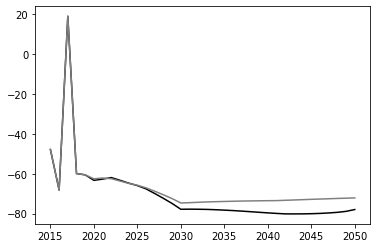

In [229]:
df_tmp = pd.read_csv(sr.fp_csv_output_multi_sector_analytica)
fields_fo = [x for x in df_tmp.columns if "fo-" in x]

field_total = fields_fo[7]#"fo-aov-incendios-mtco2e"
df1 = df_tmp[(df_tmp["master_id"].isin([11]))][["year", field_total]]
df2 = df_tmp[(df_tmp["master_id"].isin([33]))][["year", field_total]]

x1 = np.array(df1["year"])
y1 = np.array(df1[field_total])
plt.plot(x1, y1, color = "black")

x2 = np.array(df2["year"])
y2 = np.array(df2[field_total])
plt.plot(x2, y2, color = "gray")

#y3 = np.zeros(len(x2))
#plt.plot(x2, y3, color = "red", alpha = 0.3)

plt.show()

In [224]:
df_tmp

,master_id,year,ag-aov-aplicación_de_urea-mtco2e,ag-aov-captura_de_c_en_suelo-mtco2e,ag-aov-fermentacion_entérica-mtco2e,ag-aov-gestión_de_estiercol-mtco2e,ag-aov-suelos_agricolas-mtco2e,ag-emissions_total-mtco2e,fo-aov-4a_forestal-mtco2e,fo-aov-4b_cultivo-mtco2e,...,ip-aov-e_industria_electrónica-mtco2e,ip-aov-f_uso_de_productos_de_sao-mtco2e,ip-aov-g_otra_producción_y_usos-mtco2e,ip-emissions_total-mtco2e,wa-aov-a-rsu-mtco2e,wa-aov-b-compostaje-mtco2e,wa-aov-c1-incineracion-mtco2e,wa-aov-d1-aguasdomesticas-mtco2e,wa-aov-d2-aguasindustriales-mtco2e,wa-emissions_total-mtco2e
0,0,2015,0.433016,0.0,5.277093,1.581533,4.056663,11.348305,-76.415801,1.567906,...,0.0,2.425958,0.242326,6.419735,3.039107,0.059947,0.000479,0.970100,0.031893,4.101526
1,0,2016,0.356951,0.0,5.116427,1.559046,4.038806,11.071230,-75.681598,1.549870,...,0.0,2.721732,0.272268,6.890143,3.115061,0.059947,0.000533,0.956431,0.015828,4.147801
2,0,2017,0.401220,0.0,5.083247,1.556082,4.012020,11.052569,-70.987040,1.546357,...,0.0,3.028814,0.271731,7.220645,3.280821,0.059947,0.000473,0.941397,0.015828,4.298467
3,0,2018,0.406445,0.0,5.054976,1.553479,4.005776,11.020677,-67.848356,1.546062,...,0.0,3.504708,0.276276,7.831667,3.442049,0.059947,0.000513,0.991558,0.015828,4.509896
4,0,2019,0.411450,0.0,5.166323,1.844815,4.161648,11.584236,-70.895989,1.547679,...,0.0,3.952454,0.278406,8.473485,3.607325,0.059947,0.000497,1.008970,0.015828,4.692568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,43,2046,0.462961,0.0,4.859395,2.001053,4.596350,11.919758,-80.647374,1.582117,...,0.0,2.841849,0.351809,8.464679,5.873015,0.059947,0.005291,1.223036,0.015828,7.177117
1580,43,2047,0.461772,0.0,4.855461,2.040236,4.614283,11.971751,-80.411169,1.580306,...,0.0,2.243818,0.354472,7.903367,5.987817,0.059947,0.005647,1.223792,0.015828,7.293031
1581,43,2048,0.460361,0.0,4.851590,2.079672,4.632384,12.024008,-80.177595,1.578296,...,0.0,1.674180,0.358260,7.371213,6.105034,0.059947,0.006020,1.224297,0.015828,7.411126
1582,43,2049,0.458730,0.0,4.847779,2.119350,4.650578,12.076437,-79.950302,1.576091,...,0.0,1.554083,0.361639,7.287804,6.224569,0.059947,0.006410,1.224553,0.015828,7.531308


In [320]:
df_par_sreps

,line_num,string_replace
0,176,set esc_selec(esc) /##master_id##/;
1,698,set h2(h) /##hydro_id##/;
2,1710,"File resultsBID / ""##fp_output##"" /;"


In [381]:
#########################################
###                                   ###
###    BUILD PARALLELIZATION FILES    ###
###                                   ###
#########################################

#read in games file
f_gams = open(sr.fp_gams_modelo, "r")
str_list_gams = f_gams.readlines()

##  get data frames

#get lines to remove
df_rm_lines = pd.read_csv(sr.fp_csv_gams_parallel_support_lines_to_remove)
#string replacements
df_par_sreps = pd.read_csv(sr.fp_csv_gams_parallel_support_string_replacements)
#get hydrology ids by master id
df_hidro = pd.read_csv(sr.fp_csv_gams_data_hidrologias_escenarios)


##  build dictionaries

#dictionary to map line numbers to strings to replace
dict_par_sreps = sr.build_dict(df_par_sreps[["line_num", "string_replace"]])
#dictionary to map master ids to hydrology id
dict_master_to_hidro = sr.build_dict(df_hidro[["Escenario", "Escenario_Hidrologico"]])

##  1. REPLACE LINES SPECIFIED

for l in dict_par_sreps.keys():
    if l < len(str_list_gams):
        #set the string to insert
        str_insert = str(dict_par_sreps[l])
        #check for appendage
        if dict_par_sreps[l][-2:] != "\n":
            str_appendage = "\n"
        else:
            str_appendage = ""
            
        #update list
        str_list_gams[int(l) - 1] = str_insert + str_appendage

        
##  2. REMOVE LINES

#initialize the set of lines to 
set_rm_lines = []

vec_lines = df_rm_lines["line_comment_0"]

# (a) loop over indexing csv to remove lines
for i in range(len(df_rm_lines)):
    
    str_lines = str(df_rm_lines["line_comment_0"].iloc[i])
    
    if str_lines.isnumeric():
        rml = [int(str_lines) - 1]
    else:
        #assume it's a range
        rml = str_lines.split("-")
        #initialize ranging
        rml_tmp = []
        #check for numeric
        for k in range(len(rml)):
            if rml[k].isnumeric():
                rml_tmp.append(int(rml[k]))
        #set range
        rml = list(range(min(rml_tmp) - 1, max(rml_tmp)))
    
    #update
    set_rm_lines = set_rm_lines + rml

set_rm_lines = set(set_rm_lines)


# (b) loop over all lines to remove calls to csv2gdx

str_flag_drop = "$call csv2gdx"
#new file to run in gams as a preprocessor (not in parallel)
new_file_calls = []

for i in range(len(str_list_gams)):
    #the line
    str_line = str(str_list_gams[i])
    #is the flag there?
    if str_line[0:min(len(str_flag_drop), len(str_line))] == str_flag_drop:
        #add to the new file
        new_file_calls.append(str_line)
        #and add to the set of lines to drop
        set_rm_lines = set_rm_lines | set({i})
        
#write output to new gams
f_gdx = open(sr.fp_gams_pmr_prerun_gdx_build, "w")
f_gdx.writelines(new_file_calls)
f_gdx.close()  

#get lines to keep
set_kp_lines = list(set(range(len(str_list_gams))) - set_rm_lines)
set_kp_lines.sort()
#reduce gams template 
str_list_gams = [str_list_gams[i] for i in set_kp_lines]


##  3. INDEX LINES THAT CONTAIN ID REPLACEMENT STRINGS

#initialize dictionary of indicies for lines that have ids
dict_ind_lines_repl_vars = {"hydro_id": [], "master_id": [], "fp_output": []}

for i in range(len(str_list_gams)):
    #the line
    str_line = str(str_list_gams[i])
    #then, check if it needs to be indexed
    for id_type in dict_ind_lines_repl_vars.keys():
        str_check = "##" + id_type + "##"
        if str_check in str_line:
            print(i)
            tmp_vec = dict_ind_lines_repl_vars[id_type]
            #update the list in the dictionary
            dict_ind_lines_repl_vars.update({id_type: tmp_vec + [int(i)]})


##  4. BUILD FUNCTION TO EXECUTE ON EACH NODE

#set dictionary for renaming columns 
dict_rename = {
    "agno": "year",
    "emission": (sr.dict_sector_to_abv["electricity"] + "-emissions_total-mtco2e"),
    "CAPEX": (sr.dict_sector_to_abv["electricity"] + "-costs_total_capex-UNITSHERE"),
    "OPEX": (sr.dict_sector_to_abv["electricity"] + "-costs_total_opex-UNITSHERE")
}

#define the function to run on each core
def run_gams(m_id, dict_line_repls = dict_ind_lines_repl_vars, fp_gams = "/usr/local/bin/gams"):
    
    #local path on OS X: fp_gams = "/Applications/GAMS30.3/GAMS Terminal.app/Contents/MacOS/gams"
    
    #get template to work withand write
    tmp = str_list_gams.copy()
    #set filename for output from gams
    fp_out_gams = sr.fp_csv_gams_solution_generation_sector.replace(".csv", ("-" + str(m_id) + ".csv"))
    
    #set dictionary of ids
    dict_vars = {
        "master_id": int(m_id), 
        "hydro_id": int(dict_master_to_hidro[int(m_id)]),
        "fp_output": fp_out_gams
    }

    # replace ids with integer values 
    for id_type in dict_line_repls.keys():
        if id_type in dict_vars.keys():
            #get lines
            for k in dict_line_repls[id_type]:
                str_rep = "##" + id_type + "##"
                #update template with real id
                tmp[k] = tmp[k].replace(str_rep, str(dict_vars[id_type]))
    
    # write to output
    fp_out = os.path.join(sr.dir_gams_modelo, "pmr_model-" + str(m_id) + ".gms")
    #set writer
    f = open(fp_out, "w")
    f.writelines(tmp)
    f.close()
    
    
    # execute command
    #cmd = "\"" + fp_gams + "\" \"" + fp_out + "\""
    cmd = "echo test"
    #execute
    rv = os.system(cmd)
    
    #read output
    if os.path.exists(sr.fp_csv_gams_solution_generation_sector):#fp_out_gams
        #get results
        df_results = pd.read_csv(sr.fp_csv_gams_solution_generation_sector)
        #ordered fields
        fields_ord = list(df_results.columns)
        #add master id
        df_results["master_id"] = [m_id for i in range(len(df_results))]
        #reorder and rename
        df_results = df_results[["master_id"] + fields_ord].rename(columns = dict_rename)

        return df_results
    else:
        return -99

    
##  5. EXECUTE IN PARALLEL, COLLECT OUTPUT, AND WRITE OUTPUT

if True:
    #change the working directory to gams
    os.chdir(sr.dir_gams_modelo)
    iters = list(range(16))
    
    if __name__ == "__main__":

        with mp.Pool() as pool:
            #k = pool.starmap(gams_test, iters)
            list_pool = pool.map(run_gams, iters)
        
        df_out = pd.concat(list_pool, axis = 0).reset_index(drop = True)
        
        #df_out.to_csv(sr.fp_csv_output_multi_sector_pmr, index = None, encoding = "UTF-8")
        

155
638
1421


In [383]:
t0 = time.time() 

In [387]:
round(time.time() - t0, 2)

14.84

In [351]:
tmp = run_gams(18, dict_ind_lines_repl_vars)
tmp[688]


'set h2(h) /16/;\n'

In [373]:
min(1, 2)

1

In [426]:
df_m = pd.read_csv(sr.fp_csv_attribute_master)
df_mr = pd.read_csv(sr.fp_csv_experimental_design_msec_masters_to_run_gams)

In [428]:
df_mr = pd.merge(df_mr, df_m, how = "left", on = ["master_id"])
df_mr = df_mr.sort_values(by = ["future_id", "time_series_id"]).reset_index(drop = True)
df_mr[["master_id"]].to_csv(sr.fp_csv_experimental_design_msec_masters_to_run_gams, index = None, encoding = "UTF-8")

In [391]:
df_check = df_check.sort_values(by = ["master_id", "year"])

In [393]:
df_check[df_check["year"] == 2050]

,master_id,year,el-emissions_total-mtco2e,el-costs_total_capex-UNITSHERE,el-costs_total_opex-UNITSHERE
14,101,2050,5.27,144.01,973.55
41,102,2050,5.27,144.01,973.55
101,103,2050,5.27,144.01,973.55


In [545]:
data_cur = pd.read_csv(sr.fp_csv_output_multi_sector_pmr)
len(data_cur["master_id"].unique())

3

In [546]:
data_cur[(data_cur["master_id"].isin([102, 304])) & (data_cur["year"].isin([2050]))]

,master_id,year,el-emissions_total-mtco2e,el-costs_total_capex-UNITSHERE,el-costs_total_opex-UNITSHERE
67,304,2050,9.43,331.42,1736.69


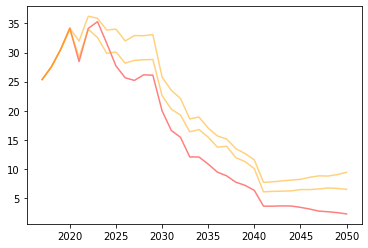

In [547]:
field = "el-emissions_total-mtco2e"

#dict_cols = {6: "blue", 18: "purple", 7: "red", 19: "orange"}
for m in data_cur["master_id"].unique():
    df_tmp = data_cur[data_cur["master_id"] == m][["year", field]].copy().sort_values(by = ["year"])
    x = np.array(df_tmp["year"])
    y = np.array(df_tmp[field])
    
    if m == 101:
        col = "black"
        opa = 1
    elif m == 303:
        col = "red"
        opa = 1
    elif m > 303:
        col = "orange"
        opa = 0.4
    elif m > 101:
        col = "gray"
        opa = 0.4
    #col = dict_cols[m]
    plt.plot(x, y, color = col, alpha = 0.5)

plt.show()

In [431]:
df_ed = pd.read_csv(sr.fp_csv_experimental_design_msec)

In [490]:
#df_ed[df_ed["year"] == 2019]
df_fp = pd.read_csv(os.path.join(sr.dir_gams_input, "data_factor_planta.csv"))
df_agnos = pd.read_csv(os.path.join(sr.dir_gams_input, "data_set_agnos.csv"))
df_fl = pd.read_csv(os.path.join(sr.dir_out, "fplanta.csv"))
df_he = pd.read_csv(sr.fp_csv_gams_data_hidrologias_escenarios)
df_he[df_he["Escenario"] == 305]


In [542]:
df_fp[(df_fp["Etapa"] == 1)&(df_fp["Proceso"] == "ABANICO")&(df_fp["Hidrologia"] == 1)]

,Escenario,Escenario_Hidrologico
507,305,1


In [601]:
#
#    KLUGE FILE
#

def get_archive_run(fp_in, archive_run):
    dir_arch = os.path.join(sr.dir_archive_runs, archive_run)
    
    if os.path.exists(dir_arch):
        fp_read = os.path.join(dir_arch, os.path.basename(fp_in))
    
        if os.path.exists(fp_read):
            out = pd.read_csv(fp_read)
        else:
            print("File '" + os.path.basename(fp_in) + "' not found in '" + dir_arch + "'.")
            out = None
    else:
        print("Archive directory '" + dir_arch + "' not found.")
        out = None
    
    return out

ar = "Chile_sector_package_2020_12_06"
df_arc_master = get_archive_run(sr.fp_csv_attribute_master, ar)
df_arc_out = get_archive_run(sr.fp_csv_output_multi_sector_pmr, ar)
#mixing vector data frame
df_mix = pd.DataFrame(np.array([sr.build_linear_mix_vec((2020, 2030), (2017, 2050))]).transpose(), columns = ["mix_factor"])
df_mix["year"] = list(range(2017, 2051))



##  BUILD DICTIONARY THAT MAPS COMBOS TO THEIR ASSOCIATED "FUTURE 0" MASTER

#ifields to use to map to future 0
fields_map = ["design_id", "strategy_id", "time_series_id"]
df_f0ms = df_arc_master[df_arc_master["future_id"] == 0][fields_map + ["master_id"]]
dict_f0ms = dict([[tuple(x[0:3]), x[3]] for x in np.array(df_f0ms)])
#set of future 0 masters
set_f0ms = set([dict_f0ms[k] for k in dict_f0ms.keys()])

#get scenario fields
fields_scen = ["master_id", "year"]
str_mid_f0 = "master_id_f0"
#get data fields to extract
fields_dat = [x for x in df_arc_out.columns if ("el-emissions" in x)]
#renaming dictionary
dict_rnm_dat_f0 = dict([[x, x + "_f0"] for x in fields_dat])
dict_rnm_dat_modeled = dict([[x, x + "_modeled"] for x in fields_dat])
#get data frame of results associated with these masters
df_arc_out_f0ms = df_arc_out[df_arc_out["master_id"].isin(set_f0ms)][fields_scen + fields_dat].copy().rename(columns = dict_rnm_dat_f0)
df_arc_out_f0ms = df_arc_out_f0ms.rename(columns = {"master_id": str_mid_f0})
#then, build a dictionary to map masters to their associated future 0 masters
dict_m_to_f0m = {}
#loop
for i in range(len(df_arc_master)):
    row = df_arc_master.iloc[i]
    m_id = int(row["master_id"])
    id_tuple = tuple([int(x) for x in np.array(row[fields_map])])
    #get the f0 master
    master_f0 = int(dict_f0ms[id_tuple])
    #add to dict out
    dict_m_to_f0m.update({m_id: master_f0})
    

##  UPDATE PMR DF WITH MASTERS TO MERGE 

#add future 0 field to merge on
df_arc_out[str_mid_f0] = df_arc_out["master_id"].replace(dict_m_to_f0m)
#rename
df_arc_out = df_arc_out.rename(columns = dict_rnm_dat_modeled)

#merge in datasets
df_arc_out = pd.merge(df_arc_out, df_arc_out_f0ms, how = "left", on = [str_mid_f0, "year"])
df_arc_out = pd.merge(df_arc_out, df_mix, how = "left", on = ["year"])

#add in the mixed output
for field in fields_dat:
    #get modeled and f0 fields
    vec_modeled = np.array(df_arc_out[field + "_modeled"])
    vec_f0 = np.array(df_arc_out[field + "_f0"])
    vec_mix = np.array(df_arc_out["mix_factor"])
    
    #get estimate
    vec_field = vec_f0*(1 - vec_mix) + vec_modeled*vec_mix
    #add to output
    df_arc_out[field] = vec_field

#reduced
df_arc_out = df_arc_out[[x for x in df_arc_out if (x not in ["mix_factor", "master_id_f0"])]]
#export
df_arc_out.to_csv(os.path.join(sr.dir_archive_runs, ar, os.path.basename(sr.fp_csv_output_multi_sector_analytica.replace(".csv", "_mixedfix.csv"))), index = None, encoding = "UTF-8")


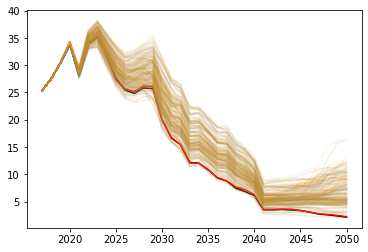

In [600]:
field = "el-emissions_total-mtco2e"

#dict_cols = {6: "blue", 18: "purple", 7: "red", 19: "orange"}
for m in df_arc_out["master_id"].unique():
    df_tmp = df_arc_out[df_arc_out["master_id"] == m][["year", field]].copy().sort_values(by = ["year"])
    x = np.array(df_tmp["year"])
    y = np.array(df_tmp[field])
    
    if m == 101:
        col = "black"
        opa = 1
    elif m == 303:
        col = "red"
        opa = 1
    elif m > 303:
        col = "orange"
        opa = 0.1
    elif m > 101:
        col = "gray"
        opa = 0.1
    #col = dict_cols[m]
    plt.plot(x, y, color = col, alpha = opa)

plt.show()

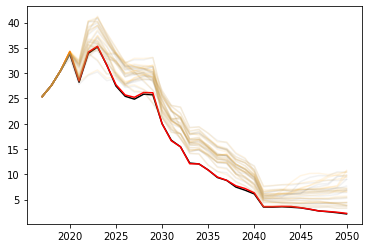

In [602]:
field = "el-emissions_total-mtco2e"

df_cur = pd.read_csv(sr.fp_csv_output_multi_sector_pmr)
#dict_cols = {6: "blue", 18: "purple", 7: "red", 19: "orange"}
for m in df_cur["master_id"].unique():
    df_tmp = df_cur[df_cur["master_id"] == m][["year", field]].copy().sort_values(by = ["year"])
    x = np.array(df_tmp["year"])
    y = np.array(df_tmp[field])
    
    if m == 101:
        col = "black"
        opa = 1
    elif m == 303:
        col = "red"
        opa = 1
    elif m > 303:
        col = "orange"
        opa = 0.1
    elif m > 101:
        col = "gray"
        opa = 0.1
    #col = dict_cols[m]
    plt.plot(x, y, color = col, alpha = opa)


In [604]:
len(df_cur["master_id"].unique())

40